# Feed-forward neural network using ozone data at Joshua Tree
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/ann_ozone_joshuatree_filled.ipynb)

* Created originally by TA Jamin Rader [CSU] for ATS 780A7 at Colorado State University led by Prof. Elizabeth Barnes

# 0. Set Up Environments

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print("IN_COLAB = " + str(IN_COLAB))

IN_COLAB = False


In [2]:
import sys
import numpy as np
import seaborn as sb

import pandas as pd
import datetime
import tensorflow as tf
import sklearn

# import pydot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# %matplotlib inline

# tf.compat.v1.disable_v2_behavior()

In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.23.2
tensorflow version = 2.10.0


In [4]:
## UNCOMMENT IF YOU WANT TO SAVE FIGURES IN COLABORATORY

# if(IN_COLAB==True):
#     try:
#         from google.colab import drive
#         drive.mount('/content/drive', force_remount=True)
#         local_path = '/content/drive/My Drive/Colab Notebooks/'
#     except:
#         local_path = './'
# else:
#     local_path = '../figures/'


# 1. Data Preparation

### 1.1 Data Overview

This is ozone and meteorlogical data from [CASTNET](https://www.epa.gov/castnet) (Clean Air Status and Trends Network) for Joshua Tree National Park, located just outside of Palm Springs and about 100 miles east of Los Angeles. The National Park Service monitors ozone in their parks. Joshua Tree has recorded at least 30 exceedance days per year [since 2016](https://www.nps.gov/subjects/air/ozone-exceed.htm). An exceedance day occurs when the daily maximum 8-hour ozone average is 71 ppb or higher. For comparison, Rocky Mountain NP has only experienced 35 ozone exceedance days since 2016.





In [5]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/ozone_data_joshuatreenp.csv"
data = pd.read_csv(url, parse_dates=["DATE_TIME"], infer_datetime_format=True)

# Fix data issue with Daylight Savings Time
duplicate_dates = data["DATE_TIME"][data.duplicated("DATE_TIME")]
for dup_date in duplicate_dates:
    idx = data["DATE_TIME"].eq(dup_date).idxmax()
    data.at[idx, "DATE_TIME"] = dup_date - pd.Timedelta(value=1, unit="hours")

# Add hour and day of year
data["HOUR"] = data["DATE_TIME"].dt.hour
data["MONTH"] = data["DATE_TIME"].dt.month
data["YEAR"] = data["DATE_TIME"].dt.year
data["DAYOFYEAR"] = data["DATE_TIME"].dt.dayofyear
data.sort_values("DATE_TIME", inplace=True, ignore_index=True)

/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_8476/3840272346.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(url, parse_dates=["DATE_TIME"], infer_datetime_format=True)
/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_8476/3840272346.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(url, parse_dates=["DATE_TIME"], infer_datetime_format=True)


Let's take a look at the data. We have data for ozone, temperature, relative humidity, and wind direction, among others.

In [6]:
display(data.head())


,SITE_ID,DATE_TIME,TEMPERATURE,TEMPERATURE_DELTA,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,FLOW_RATE,WINDSPEED_SCALAR,UPDATE_DATE,HOUR,MONTH,YEAR,DAYOFYEAR
0,JOT403,2010-01-01 00:00:00,3.4000,2.4000,29.0,0.0,46.0,0.0,3.8000,189.0,2.0,3.05,3.8000,10/30/14 10:27,0,1,2010,1
1,JOT403,2010-01-01 01:00:00,3.4000,2.5999,29.0,0.0,46.0,0.0,3.2000,189.0,5.0,3.05,3.2000,10/30/14 10:27,1,1,2010,1
2,JOT403,2010-01-01 02:00:00,3.5999,2.7000,26.0,0.0,46.0,0.0,3.5000,191.0,4.0,3.05,3.5000,10/30/14 10:27,2,1,2010,1
3,JOT403,2010-01-01 03:00:00,3.3000,2.8000,28.0,0.0,46.0,0.0,3.0999,190.0,5.0,3.05,3.0999,10/30/14 10:27,3,1,2010,1
4,JOT403,2010-01-01 04:00:00,3.2000,2.5999,32.0,0.0,45.0,0.0,3.5999,191.0,4.0,3.05,3.5999,10/30/14 10:27,4,1,2010,1


### 1.2 Define Input and Output

The 2015 benchmark for [human health ozone condition](https://www.nps.gov/articles/analysis-methods2020.htm) is shown here. Let us predict whether the ozone quality will be classified as good, fair, or poor over 8-hour periods.

**Good**   $\leq$ 54.9 ppb

**Fair**   55.0 - 70.9 ppb

**Poor**   $\geq$ 71.0 ppb

Let's start out by training our model using Temperature, Relative Humidity, Windspeed, and Day of Year.

In [7]:
# Here are all the different variables that we could use for training our neural
# nework (except ozone, of course)
data.columns


Index(['SITE_ID', 'DATE_TIME', 'TEMPERATURE', 'TEMPERATURE_DELTA',
       'RELATIVE_HUMIDITY', 'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION',
       'WINDSPEED', 'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE',
       'WINDSPEED_SCALAR', 'UPDATE_DATE', 'HOUR', 'MONTH', 'YEAR',
       'DAYOFYEAR'],
      dtype='object')

**EDIT the Input Variables Here:** Reminder, if you choose to use wind direction, you must first convert it to a vector for averaging.

In [8]:
# List of strings from the available column names in the data set
INPUT_VARIABLES = [
    "TEMPERATURE",
    "RELATIVE_HUMIDITY",
    "WINDSPEED",
    "DAYOFYEAR",
]


In [9]:
# Let's isolate our variables of interest and take the 8-hour running mean

# First using input and output variables together to take running mean
df_data_to_be_used = data[["OZONE"] + INPUT_VARIABLES]

# Here we take the 8-hour rolling mean (note: DATE_TIME does not work)
df_data_to_be_used = df_data_to_be_used.rolling(8).mean()

# Now adding Date and Time components
df_data_to_be_used[["DATE_TIME", "HOUR", "MONTH", "YEAR"]] = data[["DATE_TIME", "HOUR", "MONTH", "YEAR"]]

# Dropping NaNs
df_data_to_be_used.dropna(inplace=True)

display(df_data_to_be_used.head())

,OZONE,TEMPERATURE,RELATIVE_HUMIDITY,WINDSPEED,DAYOFYEAR,DATE_TIME,HOUR,MONTH,YEAR
7,45.125,3.299987,30.875,3.337462,1.0,2010-01-01 07:00:00,7,1,2010
8,45.125,3.749988,30.875,2.899962,1.0,2010-01-01 08:00:00,8,1,2010
9,45.375,4.374975,30.500,2.649962,1.0,2010-01-01 09:00:00,9,1,2010
10,45.625,5.074975,30.375,2.387462,1.0,2010-01-01 10:00:00,10,1,2010
11,46.000,5.862475,29.875,2.249975,1.0,2010-01-01 11:00:00,11,1,2010


In [10]:
# Creating a numpy array for our inputs and outputs
input = df_data_to_be_used[INPUT_VARIABLES].values
output_raw = df_data_to_be_used["OZONE"].values

# Creating numpy arrays for time/date info for visualizations
hour = df_data_to_be_used["HOUR"].values
month = df_data_to_be_used["MONTH"].values
year = df_data_to_be_used["YEAR"].values

# Keeping ozone as a regression problem
output = output_raw[:, np.newaxis]

In [11]:
# Printing the shapes of our input and output arrays (#samples , #dimension of input/output)
print("Input Array Shape:", input.shape)
print("Output Array Shape:", output.shape)

Input Array Shape: (92409, 4)
Output Array Shape: (92409, 1)


### 1.3 Visualizing our Data

Let's look at what our output data actually looks like.

/opt/homebrew/Caskroom/miniforge/base/envs/env-780A7f23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


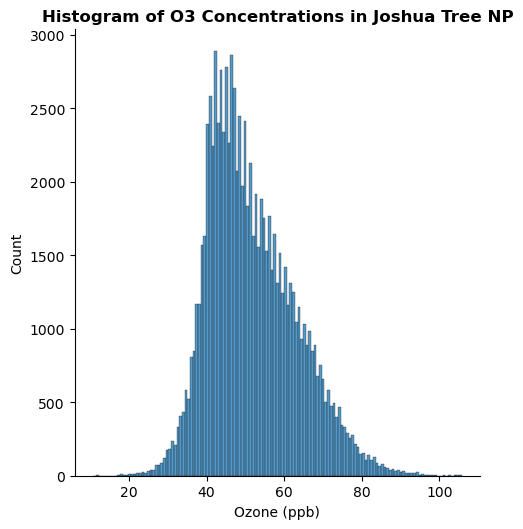

In [12]:
# Distribution of ozone concentrations
sb.displot(output_raw, kind="hist")
plt.xlabel("Ozone (ppb)")

plt.title("Histogram of O3 Concentrations in Joshua Tree NP", fontweight="demi")
plt.plot()
plt.show()

O3 Concentrations in Each Month


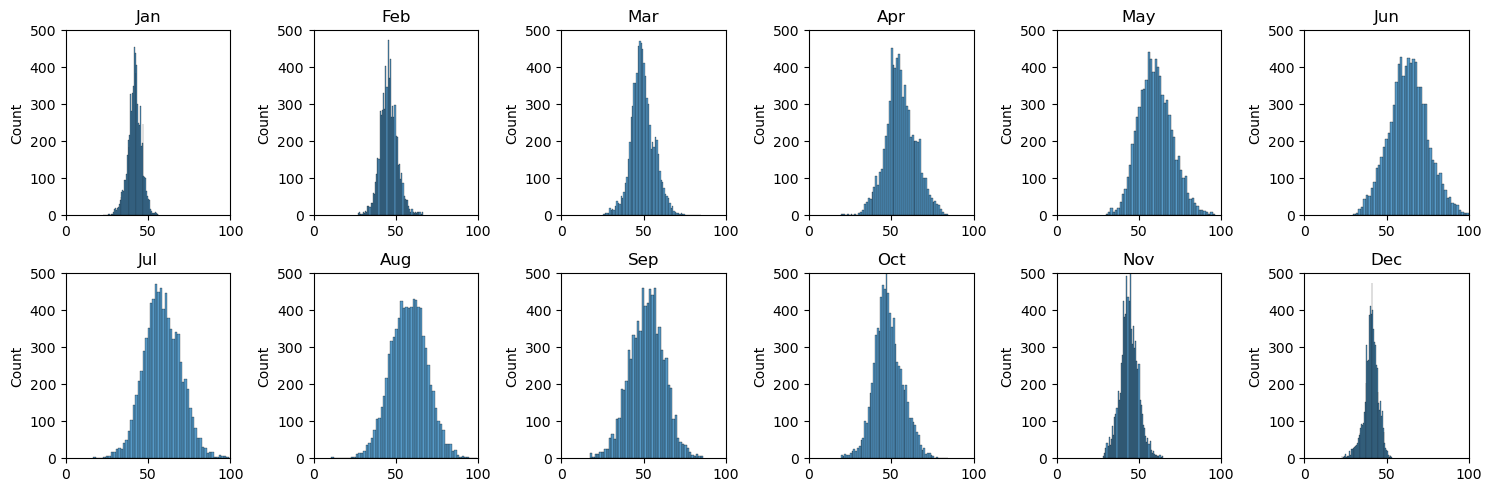

In [13]:
# Distribution of ozone concentrations in each month

fig, axs = plt.subplots(2, 6, figsize=(15, 5))

for m in np.arange(12):
    ax = axs[m // 6, m % 6]
    sb.histplot(output_raw[month == m + 1], ax=ax)
    ax.set_title(datetime.datetime.strptime(str(m + 1), "%m").strftime("%b"))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 500)

fig.tight_layout(pad=1.0)
print("O3 Concentrations in Each Month")

O3 Concentrations in Each Year


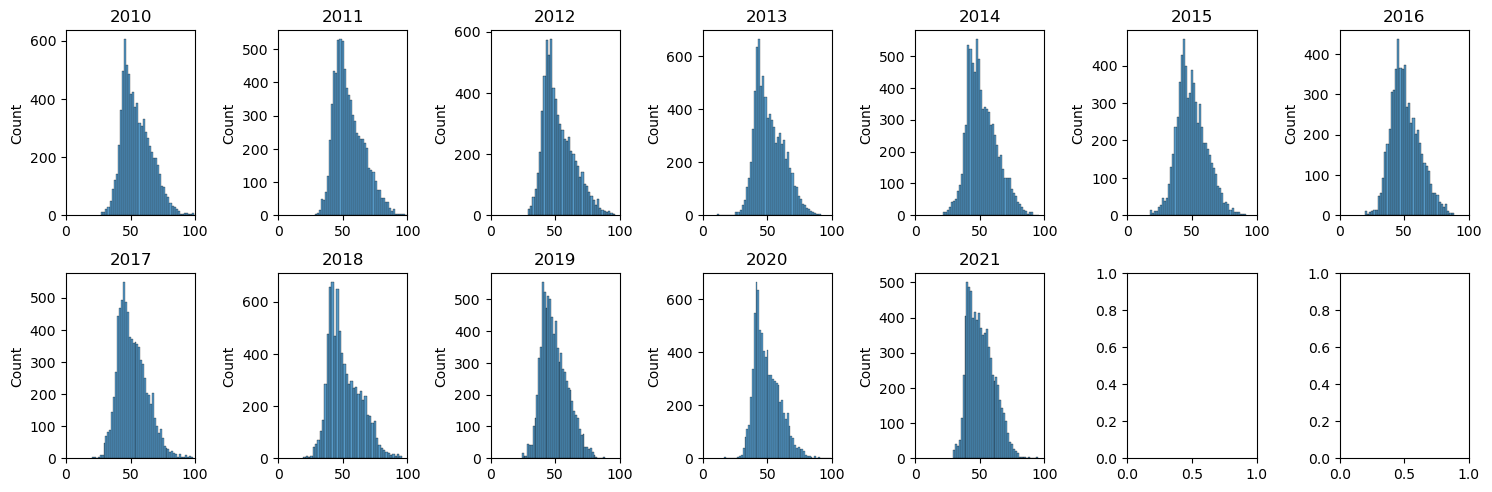

In [14]:
# Distribution of ozone concentrations in each year

fig, axs = plt.subplots(2, 7, figsize=(15, 5))

axidx = 0
for y in np.unique(year):
    ax = axs[axidx // 7, axidx % 7]
    sb.histplot(output_raw[year == y], ax=ax)
    ax.set_title(y)
    ax.set_xlim(0, 100)
    axidx += 1

fig.tight_layout(pad=1.0)
print("O3 Concentrations in Each Year")

Text(0.5, 1.0, 'Number of Usable Samples in Each Year')

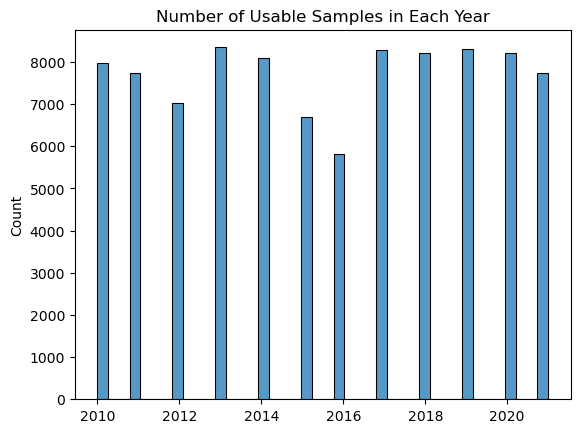

In [15]:
# How many samples are available in each year? Data cannot be used if
# there are NaNs (see 2013)
sb.histplot(year)
plt.title("Number of Usable Samples in Each Year")


### 1.4 Partitioning Data in Training, Validation, and Testing Sets

Our data is highly temporally correlated, so we are going to separate training, validation, and testing by grabbing different years of data. *Not* by random sampling.

**Some Variable Definitions**

* ```Xtrain/Xval/Xtest:*** 2-D Arrays of input data (shape: #samples, #input_variables)```

* ```Ttrain/Tval/Ttest:*** 2-D Arrays of target output data (true ozone class likelihood; shape: #samples, #classes)```

* ```Ptrain/Pval/Ptest:*** 2-D Arrays of predicted output data (predicted ozone class likelihoods; shape: #samples, #classes)```

* ```Xtrain_raw/Xval_raw/Xtest_raw:*** 2-D Arrays of raw (pre-standardized) input data (shape: #samples, #input_variables)```

* ```O3train/O3val/O3test:*** 1-D Arrays of raw ozone measurements (ppb; shape: #samples)```

* ```Cttrain/Ctval/Cttest:*** 1-D Arrays of the true ozone values (shape: #samples)```

* ```Cptrain/Cpval/Cptest:*** 1-D Arrays of the predicted ozone values (shape #samples)```

**EDIT the years used for training, validation and testing here:**

In [16]:
# Using the years 2010 - 2017 for training, 2018-2019 for validation, and 2020-2021 for testing
TRAIN_RANGE = (2010, 2017)
VAL_RANGE = (2018, 2019)
TEST_RANGE = (2020, 2021)


In [17]:
# Splitting into training, testing, validation

# This function returns a boolean array of years that fall within the given year range
year_bool = lambda yrrange: np.logical_and(year >= yrrange[0], year <= yrrange[1])

# Create the input and output arrays from training, testing, validation sets
# Inputs haven't been standardized yet (thus "_raw")

Xtrain_raw = input[year_bool(TRAIN_RANGE)]  # these are the inputs (X)
Ttrain = output[year_bool(TRAIN_RANGE)]  # these are the outputs (T is for target)

Xval_raw = input[year_bool(VAL_RANGE)]
Tval = output[year_bool(VAL_RANGE)]

Xtest_raw = input[year_bool(TEST_RANGE)]
Ttest = output[year_bool(TEST_RANGE)]

# These are the raw outputs in each set for use later
O3train = output_raw[year_bool(TRAIN_RANGE)]
O3val = output_raw[year_bool(VAL_RANGE)]
O3test = output_raw[year_bool(TEST_RANGE)]

print("Shapes:")
print("  Xtrain: ", Xtrain_raw.shape)
print("  Xval: ", Xval_raw.shape)
print("  Xtest: ", Xtest_raw.shape)
print("  Ttrain: ", Ttrain.shape)
print("  Tval: ", Tval.shape)
print("  Ttest: ", Ttest.shape)

Shapes:
  Xtrain:  (59957, 4)
  Xval:  (16512, 4)
  Xtest:  (15940, 4)
  Ttrain:  (59957, 1)
  Tval:  (16512, 1)
  Ttest:  (15940, 1)


In [18]:
# Standardizing the training, testing, and validation data

# This function takes a raw set of input fields (for example, the training,
# validation, or testing arrays), and standardizes it based on the training data.

standardize_data = lambda dat, x, s: (dat - x) / s

# Calculate mean and standard deviation of the training data INPUTS
trainmean = Xtrain_raw.mean(axis=0)
trainstd = Xtrain_raw.std(axis=0)

Xtrain = standardize_data(Xtrain_raw, trainmean, trainstd)
Xval = standardize_data(Xval_raw, trainmean, trainstd)
Xtest = standardize_data(Xtest_raw, trainmean, trainstd)

# Calculate mean and standard deviation of the training data OUTPUTS
trainmean = Ttrain.mean(axis=0).copy()
trainstd = Ttrain.std(axis=0).copy()

Tval = standardize_data(Tval, trainmean, trainstd)
Ttest = standardize_data(Ttest, trainmean, trainstd)
Ttrain = standardize_data(Ttrain, trainmean, trainstd)

/opt/homebrew/Caskroom/miniforge/base/envs/env-780A7f23/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


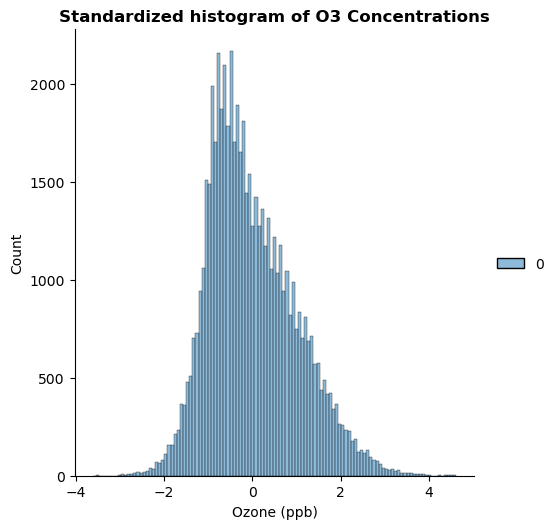

In [19]:
# Distribution of ozone concentrations
sb.displot(Ttrain, kind="hist")
plt.xlabel("Ozone (ppb)")

plt.title("Standardized histogram of O3 Concentrations", fontweight="demi")
plt.plot()
plt.show()


# 2. Neural Network

### 2.1 Building the Model

In [20]:
def my_loss(y_true, y_pred):
    # term_1 = tf.math.pow(tf.math.maximum(tf.math.abs(y_true), tf.math.abs(y_pred)), 5.0)  # symmetric
    term_1 = tf.math.pow(tf.math.abs(tf.math.maximum(y_true, y_pred)), 10.0)  # asymmetric
    term_2 = tf.math.pow((y_true-y_pred), 2.0)
    loss_value = tf.multiply(term_1, term_2)
    return tf.math.reduce_mean(loss_value)

In [21]:
def build_model(x_train, y_train, settings):
    # create input layer
    input_layer = tf.keras.layers.Input(shape=x_train.shape[1:])

    # create a normalization layer if you would like
    normalizer = tf.keras.layers.Normalization(axis=(1,))
    normalizer.adapt(x_train)
    layers = normalizer(input_layer)

    # create hidden layers each with specific number of nodes
    assert len(settings["hiddens"]) == len(
        settings["activations"]
    ), "hiddens and activations settings must be the same length."

    # add dropout layer
    layers = tf.keras.layers.Dropout(rate=settings["dropout_rate"])(layers)

    for hidden, activation in zip(settings["hiddens"], settings["activations"]):
        layers = tf.keras.layers.Dense(
            units=hidden,
            activation=activation,
            use_bias=True,
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=settings["random_seed"]),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=settings["random_seed"]),
        )(layers)

    # create output layer
    output_layer = tf.keras.layers.Dense(
        units=1,  # one unit in the output since this is a regression problem
        activation="linear",
        use_bias=True,
        bias_initializer=tf.keras.initializers.RandomNormal(seed=settings["random_seed"] + 1),
        kernel_initializer=tf.keras.initializers.RandomNormal(seed=settings["random_seed"] + 2),
    )(layers)

    # construct the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.summary()

    return model


def compile_model(model, settings):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=settings["learning_rate"]),
        loss="mae",
        # loss = my_loss,
        metrics=[
            "mse",
            "mae"
        ],
    )
    return model


In [22]:
settings = {
    "hiddens": [3, 3],
    "activations": ["relu", "relu"],
    "learning_rate": 0.0005,
    "random_seed": 33,
    "max_epochs": 1_000,
    "batch_size": 256,
    "patience": 10,
    "dropout_rate": 0.,
}

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(settings["random_seed"])

model = build_model(Xtrain, Ttrain, settings)
model = compile_model(model, settings)


2023-10-16 11:55:20.222529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-16 11:55:20.222672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-16 11:55:20.259923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-16 11:55:20.318888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-16 11:55:20.332661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)       

### 2.2 Training the Model

In [23]:
# define the early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=settings["patience"], restore_best_weights=True, mode="auto", verbose=1,
)

# train the model via model.fit
history = model.fit(
    Xtrain,
    Ttrain,
    epochs=settings["max_epochs"],
    batch_size=settings["batch_size"],
    shuffle=True,
    validation_data=[Xval, Tval],
    callbacks=[early_stopping_callback],
    verbose=2,
)


Epoch 1/1000


2023-10-16 11:55:24.556203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-16 11:55:26.210629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 - 2s - loss: 0.7893 - mse: 0.9948 - mae: 0.7893 - val_loss: 0.7485 - val_mse: 0.8803 - val_mae: 0.7485 - 2s/epoch - 9ms/step
Epoch 2/1000
235/235 - 2s - loss: 0.6933 - mse: 0.8518 - mae: 0.6933 - val_loss: 0.6102 - val_mse: 0.6616 - val_mae: 0.6102 - 2s/epoch - 7ms/step
Epoch 3/1000
235/235 - 2s - loss: 0.6449 - mse: 0.7404 - mae: 0.6449 - val_loss: 0.5887 - val_mse: 0.6087 - val_mae: 0.5887 - 2s/epoch - 7ms/step
Epoch 4/1000
235/235 - 2s - loss: 0.6266 - mse: 0.6938 - mae: 0.6266 - val_loss: 0.5757 - val_mse: 0.5781 - val_mae: 0.5757 - 2s/epoch - 7ms/step
Epoch 5/1000
235/235 - 2s - loss: 0.6139 - mse: 0.6617 - mae: 0.6139 - val_loss: 0.5680 - val_mse: 0.5586 - val_mae: 0.5680 - 2s/epoch - 6ms/step
Epoch 6/1000
235/235 - 2s - loss: 0.6031 - mse: 0.6363 - mae: 0.6031 - val_loss: 0.5592 - val_mse: 0.5389 - val_mae: 0.5592 - 2s/epoch - 7ms/step
Epoch 7/1000
235/235 - 2s - loss: 0.5920 - mse: 0.6126 - mae: 0.5920 - val_loss: 0.5482 - val_mse: 0.5194 - val_mae: 0.5482 - 2s/epoch - 

# 3. Model Performance

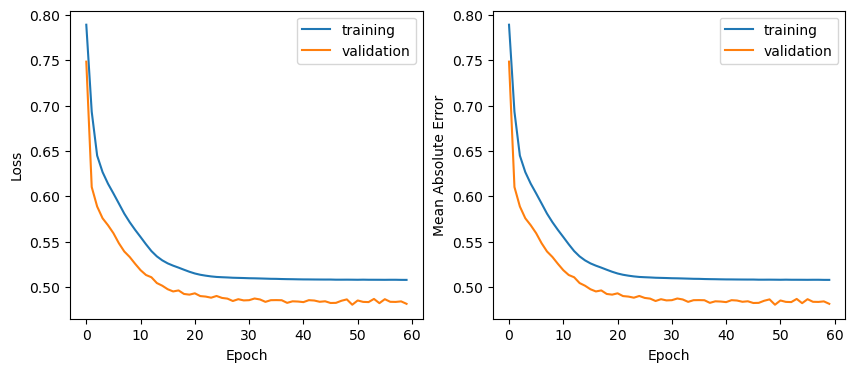

In [24]:
# Let's plot the change in loss and categorical_accuracy

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(history.history["loss"], label="training")
axs[0].plot(history.history["val_loss"], label="validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(history.history["mae"], label="training")
axs[1].plot(history.history["val_mae"], label="validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Mean Absolute Error")
axs[1].legend()

In [25]:
# What predictions did the model make for our training, validation, and test sets?
Ptrain = model.predict(Xtrain)  # Array of predictions
Pval = model.predict(Xval)
Ptest = model.predict(Xtest)

  80/1874 [>.............................] - ETA: 3s

2023-10-16 11:56:57.208957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 1s 2ms/step


Text(0, 0.5, 'predicted value')

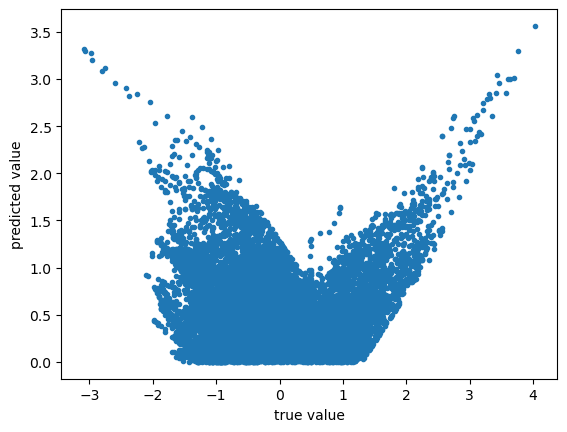

In [26]:
error_test = np.abs(Ptest - Ttest)[:,0]
plt.figure()
plt.plot(Ttest, error_test, ".")
plt.xlabel("true value")
plt.ylabel("predicted value")

In [27]:
# raise Exception("stop code prior to explainability techniques")

# 4. Explainability Techniques

### 4.1 SHAP (SHapley Additive exPlanations)

We know the accuracy of our neural network. When it makes correct predictions, is it making the right prediction for the right reasons? This is where explainable AI comes in.

Below we will use DeepSHAP to understand how our neural network made its predictions. 

In [28]:
if IN_COLAB:
    # Installing SHAP
    %pip install shap

import shap
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [29]:
# DeepSHAP takes a long time, so we make it easier by letting it learn the
# relationships between the features in a subset of the training set.
background = Xtrain[np.random.choice(Xtrain.shape[0], 100, replace=False)]

# We will use this to explain the neural network's decision-making process
explainer = shap.DeepExplainer(model, background)

# Selecting data for when a prediction was correct
Xclose = Xtest[error_test<0.05]
print(f"{Xclose.shape=}")

# These are the SHAP values for when a prediction was correct
shap_values_close = explainer.shap_values(Xclose)[0]

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Xclose.shape=(1223, 4)


2023-10-16 11:57:04.483174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [30]:
# Reduce noise by taking means of sorted 1% segments of the data
def get_percentile_stats(arr, sortarr, num=100, func=np.mean):
    sorted_arr = arr[np.argsort(sortarr)]  # Sorts arr based on values in sortarr
    split_arrs = np.array_split(sorted_arr, num)  # Splits the array into [num] lists
    meanslist = list(map(func, split_arrs))  # Applies np.mean to all arrays in split_arrs
    return np.array(meanslist)  # Returns array of the means for [num] sorted segments of arr


# Plot out the Shapley Values in a more visually appealing format
def plot_shap(shapvals, featurevals, title=False):
    # Number of samples
    samp_num = shapvals.shape[0]

    # Init colormap
    n = len(INPUT_VARIABLES)
    color = iter(plt.cm.get_cmap("viridis")(np.linspace(0, 1, n)))

    for varindex, varname in enumerate(INPUT_VARIABLES):
        # Step color
        c = next(color)

        # Get the avg feature val for every 5 percentiles of shap values
        featuremean_for_shappercentile = get_percentile_stats(featurevals[:, varindex], shapvals[:, varindex])

        # Get the median shap val for every 5 percentiles of shap values
        shapmedian_for_shappercentile = get_percentile_stats(
            shapvals[:, varindex], shapvals[:, varindex], func=np.median
        )

        # Plot
        plt.plot(featuremean_for_shappercentile, shapmedian_for_shappercentile, "o", label=varname, color=c)
        plt.axhline(0, zorder=0, color="k", alpha=0.1)
        plt.axvline(0, zorder=0, color="k", alpha=0.1)

    plt.xlim(-3, 3)
    plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")

    plt.ylabel("Median Shap Value")
    plt.xlabel("Mean Feature Value")
    if title:
        plt.title(
            "SHAP Values and Feature Values when \nNeural Network correctly "
            + "predicts '"
            + title
            + "' Ozone\nN="
            + str(samp_num)
        )
    plt.show()

The plots below are de-noised versions of all our SHAP values. They tell us two things:

1) When a certain class of ozone was correctly predicted, what did the feature values look like? For example, when a 'Good' day was correctly predicted, were the temperature values generally warmer or cooler than average (data is standardized, so the average is zero).

2) When a certain class of ozone was correctly predicted, how did changes in the feature values allow the network to be more certain (positive SHAP values) or less certain (negative SHAP values) in its prediction? For example, when windspeed was higher did this make the neural network more confident in predicting a 'Poor' ozone day?

See what you can learn about the relationship between ozone and the input features by looking at these plots.

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


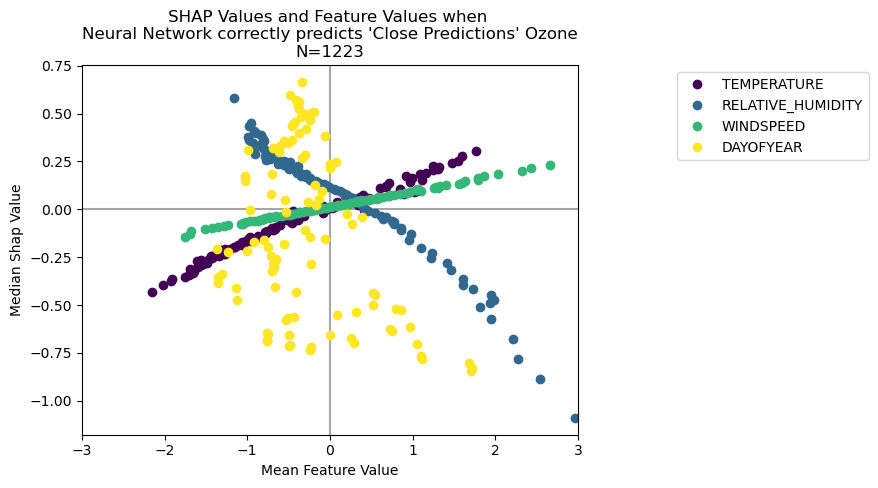

In [31]:
plot_shap(shap_values_close, Xclose, title="Close Predictions")